In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import xarray as xr

In [ ]:
# Read in file
column = ['objID','z','uMAG','rMAG','u-r','SVMPython']
df = pd.read_csv("dataset.tsv", sep='\t', header=None, names = column)
df.describe()


,objID,z,uMAG,rMAG,u-r,SVMPython
count,3.160310e+05,316031.000000,316031.000000,316031.000000,316031.000000,316031.000000
mean,1.237662e+18,0.063504,-18.495233,-20.575399,2.080166,0.558053
std,6.022167e+12,0.023058,1.034802,1.140994,0.610873,0.496619
min,1.237646e+18,0.003001,-26.045010,-25.957740,-3.803460,0.000000
25%,1.237658e+18,0.045979,-19.147785,-21.304710,1.660000,0.000000
50%,1.237662e+18,0.067202,-18.601710,-20.713750,2.158930,1.000000
75%,1.237665e+18,0.082217,-18.002450,-20.047520,2.500980,1.000000
max,1.237680e+18,0.100000,54.116670,-13.083160,78.125900,1.000000


In [ ]:
# Selecting only 0.05 < z < 0.08 and spiral (late-type!) (SVMPython = 1), randomly sample 10,000 galaxies
df = df[(df['z']<0.08) & (df['z']>0.05) & (df['SVMPython']==1) & (df['uMAG']<50) & (df['rMAG']>-22)]
print("Dataframe size post-cut:",df.size)
df = df.sample(n=10000)

Dataframe size post-cut: 413856


In [ ]:
max(df['uMAG'])

-8.49766

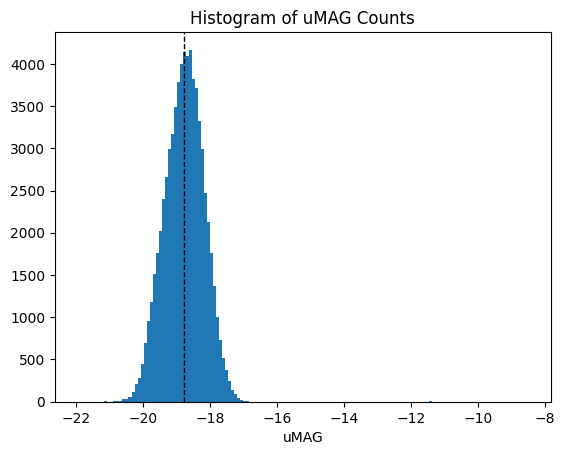

-19.56337 -18.045270000000002


In [ ]:

plt.hist(df['uMAG'], bins=150)
plt.axvline(df['uMAG'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Histogram of uMAG Counts")
plt.xlabel("uMAG")
plt.show()
print(np.percentile(df['uMAG'],10),np.percentile(df['uMAG'],90)) # Find the censor range for later

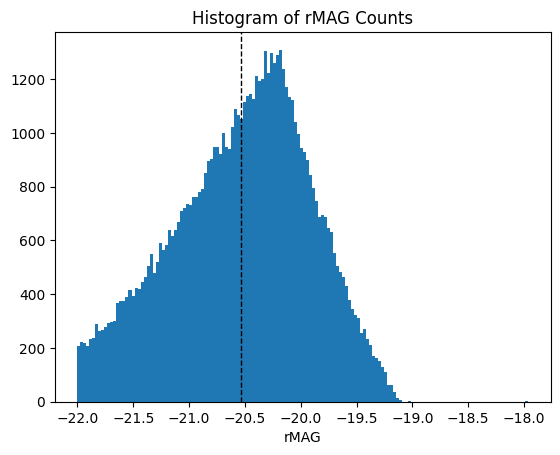

In [ ]:
plt.hist(df['rMAG'], bins=150)
plt.axvline(df['rMAG'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Histogram of rMAG Counts")
plt.xlabel("rMAG")
plt.show()

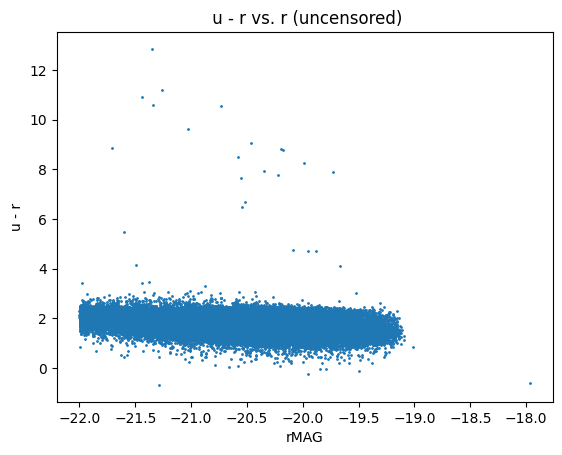

In [ ]:
plt.scatter(df['rMAG'], df['u-r'],s=1)
plt.xlabel("rMAG")
plt.ylabel('u - r')
plt.title(" u - r vs. r (uncensored)")
plt.show()

In [ ]:
# Adding censored data column for -19.5 < uMAG < -18.1
print(len(df[df["uMAG"]>-18]))
df['censored_uMAG'] = df['uMAG'].clip(upper=-18,lower=-19.5) # Made the censoring code a little prettier
censored_array=np.array([])
for i in np.array(df["uMAG"]): # This code is ugly - does pandas have a way to do this itself?
    if (i<-18 and i>-19.5):
        censored_array=np.append(censored_array,False)
    else:
        censored_array=np.append(censored_array,True)
df['censored']=censored_array
df.head()
#df.loc[df['censored_uMAG'] > -17,'censored_uMAG'] = -17 (Old code)

5918


,objID,z,uMAG,rMAG,u-r,SVMPython,censored_uMAG,censored,censored_u-r
14,1237657191978959149,0.054081,-17.99052,-20.15613,2.16561,1,-18.00000,1.0,2.05613
15,1237652946915033262,0.076573,-18.37027,-20.59320,2.22293,1,-18.37027,0.0,2.22293
19,1237663275780276438,0.078158,-19.63197,-21.30671,1.67474,1,-19.50000,1.0,1.80671
28,1237652947988840510,0.076858,-19.03226,-20.32865,1.29639,1,-19.03226,0.0,1.29639
29,1237652947988840515,0.055045,-18.23807,-19.91507,1.67700,1,-18.23807,0.0,1.67700


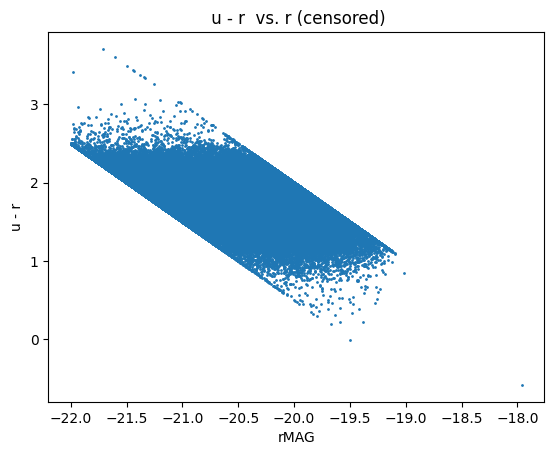

In [ ]:
df['censored_u-r'] = df['censored_uMAG'] - df['rMAG']
plt.scatter(df['rMAG'], df['censored_u-r'], s=1)
plt.xlabel("rMAG")
plt.ylabel('u - r')
plt.title(" u - r  vs. r (censored)")
plt.show()

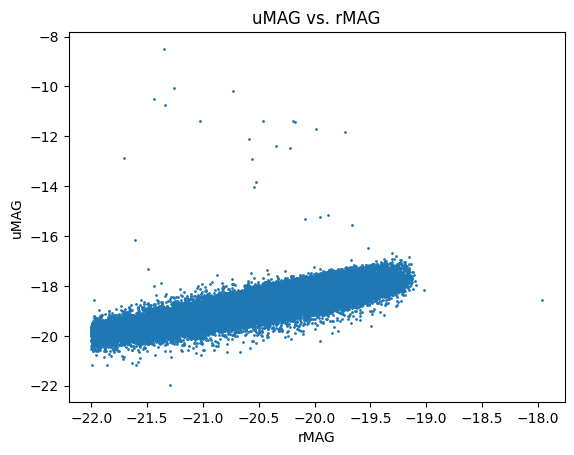

In [ ]:
plt.scatter(df['rMAG'], df['uMAG'], s=1)
plt.xlabel('rMAG')
plt.ylabel('uMAG')
plt.title('uMAG vs. rMAG')
plt.show()

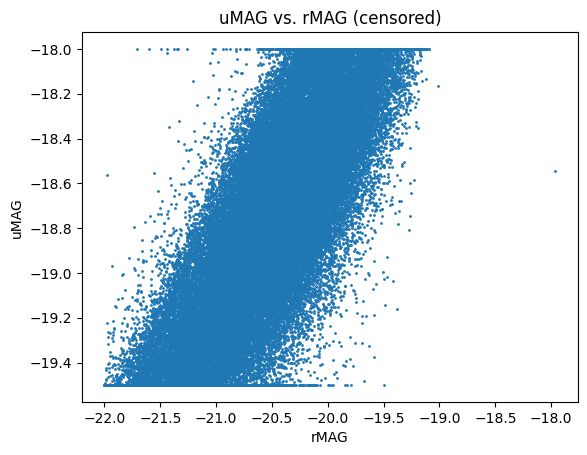

In [ ]:
plt.scatter(df['rMAG'], df['censored_uMAG'], s=1)
plt.xlabel('rMAG')
plt.ylabel('uMAG')
plt.title('uMAG vs. rMAG (censored)')
plt.show()

# `u-r vs r (uncensored)`

In [ ]:
def lregression(x, y):
    with pm.Model() as model:
        slope = pm.Normal("slope", mu=0, sigma=1)
        intercept = pm.Normal("intercept", mu=0, sigma=1)
        sigma = pm.HalfNormal("sigma", sigma=1)
        y_likelihood = pm.Normal("y_likelihood", mu=slope * x + intercept, sigma=sigma, observed=y)
    return model

In [ ]:
q1_model = lregression(df['rMAG'], df['u-r'])

with q1_model:
    q1_fit = pm.sample(return_inferencedata=True, draws = 5000)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

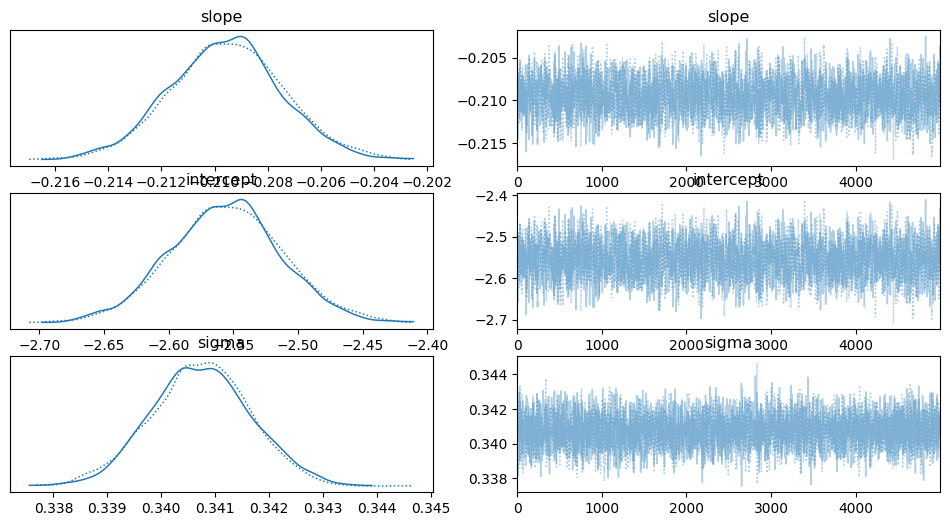

In [ ]:
az.plot_trace(q1_fit)

In [ ]:
summ=az.summary(q1_fit)
summ

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,-0.210,0.002,-0.214,-0.206,0.000,0.000,2888.0,3375.0,1.0
intercept,-2.556,0.043,-2.637,-2.472,0.001,0.001,2889.0,3284.0,1.0
sigma,0.341,0.001,0.339,0.342,0.000,0.000,4392.0,4310.0,1.0


[Text(0.5, 1.0, 'u-r vs r (uncensored data) fit'), None]

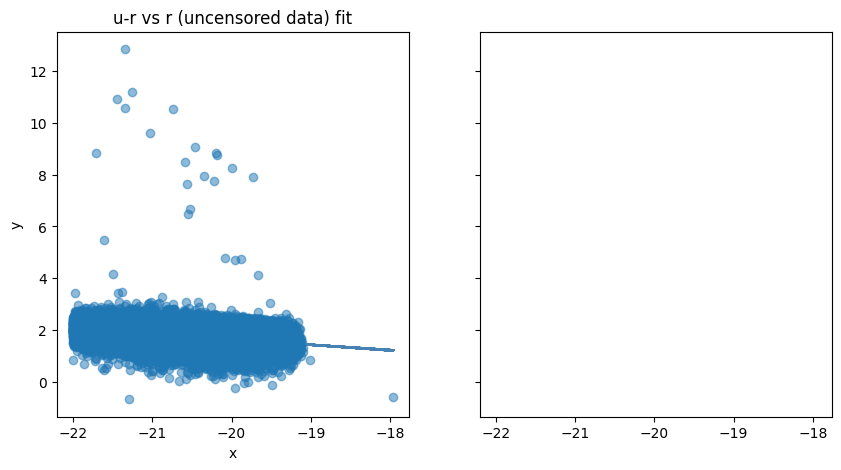

In [ ]:
def pp_plot(xx, yy, fit, ax,true=True):
    # plot posterior predicted... samples from posterior
    xi = xr.DataArray(np.array([np.min(xx), np.max(xx)]), dims=["obs_id"])
    post = fit.posterior
    y_ppc = xi * post["slope"] + post["intercept"]
    ax.plot(xi, y_ppc.stack(sample=("chain", "draw")), c="steelblue", alpha=0.01, rasterized=True)
    ax.set(xlabel="x", ylabel="y")


fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].scatter(df['rMAG'], df['u-r'],alpha=0.5)
pp_plot(df['rMAG'], df['u-r'], q1_fit, ax[0],true=True)
ax[0].set(title="u-r vs r (uncensored data) fit",alpha=0.5)